# Regime classification
This Notebook reads discharge observations for a test river basin in order to classify the basin's regime using circular statistics ([Burn et al., 2010](https://doi.org/10.1002/hyp.7625)). Based on a combination of three different peak events identification metrics, it identifies whether the basin has a nival (i.e., snowmelt-driven regime). For the analysis presented in Arnal et al. (2023) - add paper link - we selected basins across Canada and the USA with a nival regime according to all three metrics.

Decisions:
- We perform a linear interpolation of the daily discharge data before running the regime classification, to fill in small data gap of maximum 15 days. See user-specified variables below.
- The nival regime definition (i.e., start and end doy & minimum regularity) was pre-defined by Paul Whitfield (USask) from expert knowledge of Canadian hydrology. See user-specified variables below.
- The water year definition: October 1st to September 30th. See user-specified variables below.
- For the peak over threshold calculations, the threshold used is the minimum value of all annual maxima.

The "Variables" section below is the only section a user will need to modify for testing different options for most of these decisions.

Notes:
- There are no checks for water year completeness, which shouldn't be an issue with the datasets I provide as the freshet periods are captured on either end (i.e., the streamflow data starts on 1st January and ends on 31st December).

## Modules, settings, and functions

In [1]:
# Import required modules
import logging
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from pprint import pprint
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xarray as xr

In [2]:
# Add scripts to the system path
sys.path.append('../scripts')

# Set up logging, configured for this workflow (see utilities.py)
from utilities import setup_logging, read_settings
setup_logging()

# Set up logging for this notebook
logger = logging.getLogger()

# Suppress misc. comments from being added to the log file
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

%load_ext autoreload
%autoreload 2

2024-10-10 11:02:35,837 - root - INFO - Logging setup complete. Log file: C:\Users\lauri\PycharmProjects\FROSTBYTE\logs\data_driven_forecasting_20241010_110235.log


In [3]:
# Save Notebook name to the log file
logger.debug(f'Notebook: 1_RegimeClassification')

In [4]:
# Read settings file
settings = read_settings('../settings/config_test_case.yaml', log_settings=True)
pprint(settings)

2024-10-10 11:02:36,059 - root - INFO - Settings logged from ../settings/config_test_case.yaml


{'SWE_obs_path': '../test_case_data/input_data/SWE_1979_2022_testcases.nc',
 'basins_dem_path': '../test_case_data/input_data/MERIT_Hydro_dem_',
 'basins_shp_path': '../test_case_data/input_data/basins_testcases.shp',
 'domain': '05BB001',
 'output_data_path': '../test_case_data/output_data/',
 'plots_path': '../test_case_data/output_plots/',
 'precip_obs_path': '../test_case_data/input_data/SCDNA_v1.1_testcases.nc',
 'streamflow_obs_path': '../test_case_data/input_data/Qobs_1979_2021_testcases.nc'}


In [5]:
# Import required functions
from functions import regime_classification, polar_plot

## Variables

In [6]:
# Set user-specified variables
test_basin_id = settings['domain'] # Can override this with testbasin_id = <string of the testbasin id>, make sure that this id is in the input data files
nival_start_doy_default = 60 # nival regime starting day of year, corresponds to the 1st of March
nival_end_doy_default = 213  # nival regime ending day of year, corresponds to the 1st of August
nival_regularity_threshold_default = 0.65  # nival regime minimum regularity threshold
month_start_water_year_default, day_start_water_year_default = 10, 1  # water year start
month_end_water_year_default, day_end_water_year_default = 9, 30  # water year end
max_gap_days_default = 15  # max. number of days for gaps allowed in the daily streamflow data for the linear interpolation

In [7]:
# Save the user-specified variables to the log file
logger.debug(f'test basin ID: {test_basin_id}')
logger.debug(f'nival regime start DOY: {nival_start_doy_default}')
logger.debug(f'nival regime end DOY: {nival_end_doy_default}')
logger.debug(f'regularity threshold: {nival_regularity_threshold_default}')
logger.debug(f'water year start (month/day): {month_start_water_year_default}/{day_start_water_year_default}')
logger.debug(f'water year end (month/day): {month_end_water_year_default}/{day_end_water_year_default}')
logger.debug(f'linear interpolation maximum gap (days): {max_gap_days_default}')

## Read data

In [25]:
# Read the basin outlet's daily streamflow data as a DataArray 
Qobs_ds = xr.open_dataset(settings['streamflow_obs_path'])
display(Qobs_ds)
Qobs_testbasin_ds = Qobs_ds.where(Qobs_ds.Station_ID==test_basin_id, drop=True)
Qobs_testbasin_ds = Qobs_testbasin_ds.set_index({"Station_ID":"Station_ID"})

display(Qobs_testbasin_ds)

<xarray.Dataset>
Dimensions:     (Station_ID: 2, time: 15706)
Coordinates:
  * Station_ID  (Station_ID) object '05BB001' '09081600'
  * time        (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2021-12-31
    lat         (Station_ID) float64 ...
    lon         (Station_ID) float64 ...
    source      (Station_ID) object ...
Data variables:
    Flow        (time, Station_ID) float64 ...
    Flag        (time, Station_ID) object ...
Attributes:
    info:     Sample data created by Louise Arnal (USask) on August 17, 2023....

<xarray.Dataset>
Dimensions:     (Station_ID: 1, time: 15706)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2021-12-31
    lat         (Station_ID) float64 51.17
    lon         (Station_ID) float64 -115.6
    source      (Station_ID) object 'WSC_HYDAT'
Dimensions without coordinates: Station_ID
Data variables:
    Flow        (time, Station_ID) float64 9.83 10.7 10.9 10.8 ... nan nan nan
    Flag        (time, Station_ID) object 'B' 'B' 'B' 'B' 'B' ... '' '' '' '' ''
    Station_ID  (Station_ID) object '05BB001'
Attributes:
    info:     Sample data created by Louise Arnal (USask) on August 17, 2023....

<IPython.core.display.Javascript object>


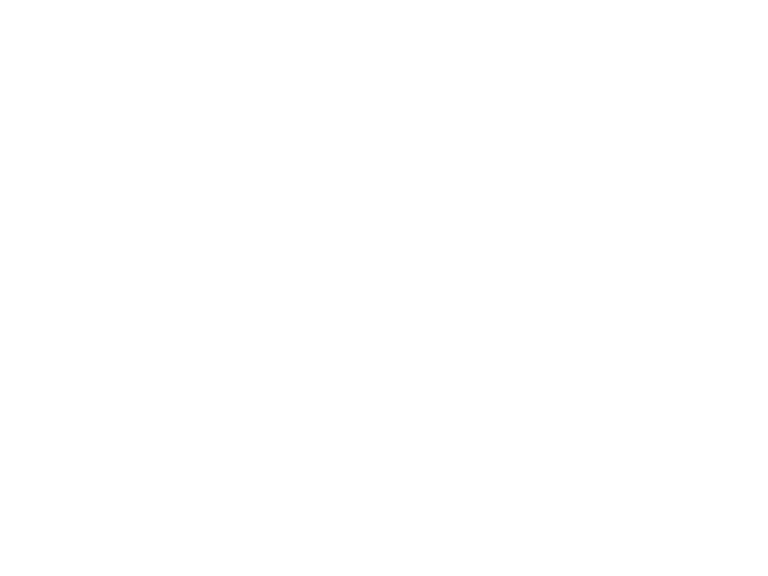

In [9]:
# Plot a climatological hydrograph for the basin
fig = plt.figure()
streamflow_data_da = Qobs_testbasin_ds.Flow
doy_mean = streamflow_data_da.groupby("time.dayofyear").mean(skipna=True)
plt.plot(np.arange(366), doy_mean.values, color='b')
plt.ylabel('mean climatological streamflow [m3/s]')
plt.xticks(np.arange(0,360,30),['1st Jan', '1st Feb', '1st Mar', '1st Apr', '1st May', '1st Jun', '1st Jul', '1st Aug', '1st Sep', '1st Oct', '1st Nov', '1st Dec'], rotation=45)
plt.tight_layout();

For this and any subsequent interactive plots, don't forget to press the "Stop Interaction" button on the top left of the plot once you're done exploring the results. Otherwise new plots will overwrite existing plots.

In [10]:
# Save the figure
fig.savefig(settings['plots_path']+"hydrograph_basin"+settings['domain']+".png", dpi=300)

In [11]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

## Circular statistics for regime classification
Below, we calculate three streamflow statistics that can be used for peak streamflow events identification: streamflow annual maxima, peaks over threshold (POT) & centre of mass (or centre of volume). We use a combination of three statistics to get more a robust output.

### Annual maxima

In [12]:
# Regime classification based on streamflow annual maxima (flag=1)
regime_annualmax_gdf, theta_rad_events_annualmax = regime_classification(Qobs_testbasin_ds, start_water_year=(month_start_water_year_default, day_start_water_year_default), max_gap_days=max_gap_days_default, flag=1)

display(regime_annualmax_gdf)
print(theta_rad_events_annualmax)

,source,Station_ID,geometry,circular_stats_theta_rad,circular_stats_regularity,mean_peak_doy
0,WSC_HYDAT,05BB001,POINT (-115.57177 51.17223),2.820109,0.978278,163.948193


[2.82312984 2.45490573 2.53048833 2.97805769 2.59934515 3.12442548
 2.49605992 2.63377357 2.89198666 2.74674768 2.87477246 3.02970031
 3.18462817 2.83258354 2.63377357 3.06412873 2.7198446  2.76391485
 2.70263039 2.54770254 2.92641507 3.15875983 2.56491674 3.09855714
 2.78870142 2.81541637 2.9952719  2.42720309 2.7198446  3.14159265
 2.89198666 3.11577134 2.9952719  2.7295805  2.96084349 3.04691452
 2.75427301 2.74674768 2.66820198 2.62657746]


This outputs a table (regime_annualmax_gdf) showing the average angular value (in radians) for all peak events combined (circular_stats_theta_rad), the regularity (circular_stats_regularity), and the average peak day of year (mean_peak_doy). The regularity is a measure of the spread in the dates of occurrences of peak events, which varies from zero to one. Larger values indicate a higher level of regularity (i.e., less spread in the dates). The list of numbers (theta_rad_events) shows the angular values of individual peak events, need for the plot below.

<IPython.core.display.Javascript object>


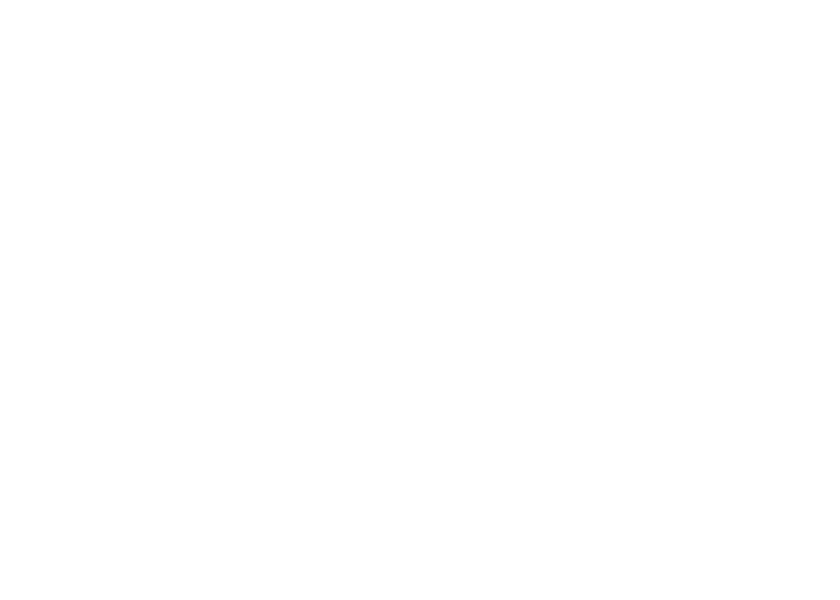

In [13]:
# Polar plot
fig = polar_plot(theta_rad_events_annualmax, regime_annualmax_gdf.circular_stats_regularity.values, flag=0, nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default, nival_regularity_threshold=nival_regularity_threshold_default)

This is a polar plot showing the dates of all individual peak events (i.e., here annual maxima) as dark squares. The average (i.e., circular mean) of these events is shown as the blue circle, giving an indication of the average date of peak events (position along the circle), as well as its regularity (position along the radius; with 0 at the centre of the circle and 1 at the edge of the circle). The basin's regime is classified as being nival if it falls within the light blue band (i.e., average peak between 1st March and 1st August, and a regularity of at least 0.65).

In [14]:
# Save the figure
fig.savefig(settings['plots_path']+"polar_plot_annualmax_basin"+settings['domain']+".png", dpi=300)

In [15]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

We will now go through the same process, but instead of the streamflow annual maxima, we will use the peaks over threshold (POT) metric to identify peak events.

### Peaks over threshold (POT)
The threshold used for this streamflow peak metric is the smallest annual maximum over the historical period. All peaks above this threshold will be counted as peak events to classify the basin's regime.

In [16]:
# Regime classification based on POT (flag=2)
regime_POT_gdf, theta_rad_events_POT = regime_classification(Qobs_testbasin_ds, start_water_year=(month_start_water_year_default, day_start_water_year_default), max_gap_days=max_gap_days_default, flag=2)

display(regime_POT_gdf)
print(theta_rad_events_POT)

,source,Station_ID,geometry,circular_stats_theta_rad,circular_stats_regularity,mean_peak_doy
0,WSC_HYDAT,05BB001,POINT (-115.57177 51.17223),2.994991,0.953249,174.117867


[2.53048833 2.65098777 2.66820198 ... 3.5536048  3.69094219 3.70810936]


You can already start noticing differences between the statistics output with this streamflow peak metric compared to the previous.

<IPython.core.display.Javascript object>


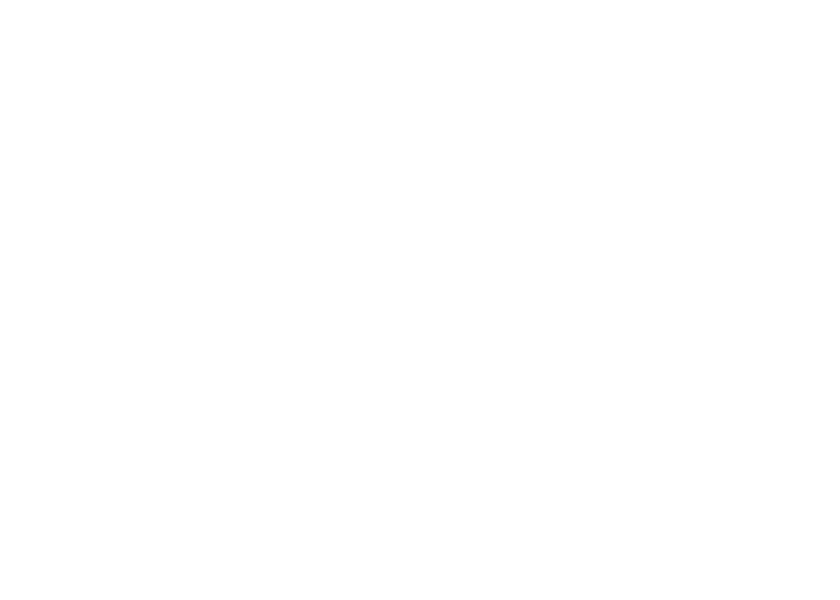

In [17]:
# Polar plot
fig = polar_plot(theta_rad_events_POT, regime_POT_gdf.circular_stats_regularity.values, flag=0, nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default, nival_regularity_threshold=nival_regularity_threshold_default)

Note that there are more events for the streamflow POT than for the two other metrics because multiple events can be identified per year, and years with missing values aren't discarded, but they are for the two other metrics calculations.

In [18]:
# Save the figure
fig.savefig(settings['plots_path']+"polar_plot_POT_basin"+settings['domain']+".png", dpi=300)

In [19]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

Finally, we will go through the same process using the centre of mass (COM) to identify peak events.

### Centre of mass (COM)
The centre of mass is the date on which 50% of the water-year streamflow occurs.

In [20]:
# Regime classification based on COM (flag=3)
regime_COM_gdf, theta_rad_events_COM = regime_classification(Qobs_testbasin_ds, start_water_year=(month_start_water_year_default, day_start_water_year_default), max_gap_days=max_gap_days_default, flag=3)

display(regime_COM_gdf)
print(theta_rad_events_COM)

,source,Station_ID,geometry,circular_stats_theta_rad,circular_stats_regularity,mean_peak_doy
0,WSC_HYDAT,05BB001,POINT (-115.57177 51.17223),2.990039,0.994148,173.827031


[3.13298555 2.83258354 3.15019976 3.06412873 3.01248611 3.14159265
 2.92641507 2.90920087 2.85755825 2.96992092 3.01248611 3.02970031
 3.11577134 2.93558658 2.97805769 2.96084349 2.9952719  3.05575679
 2.90920087 2.82312984 3.25348499 3.12442548 2.94362928 3.06412873
 2.90920087 3.02142244 2.90920087 2.77148722 2.92641507 3.02142244
 2.9952719  3.08134293 3.02970031 3.05575679 2.97805769 3.06412873
 2.80591563 2.74674768 3.04691452 3.03858962]


Again, you can notice differences between the statistics output with this streamflow peak metric compared to the other two metrics.

<IPython.core.display.Javascript object>


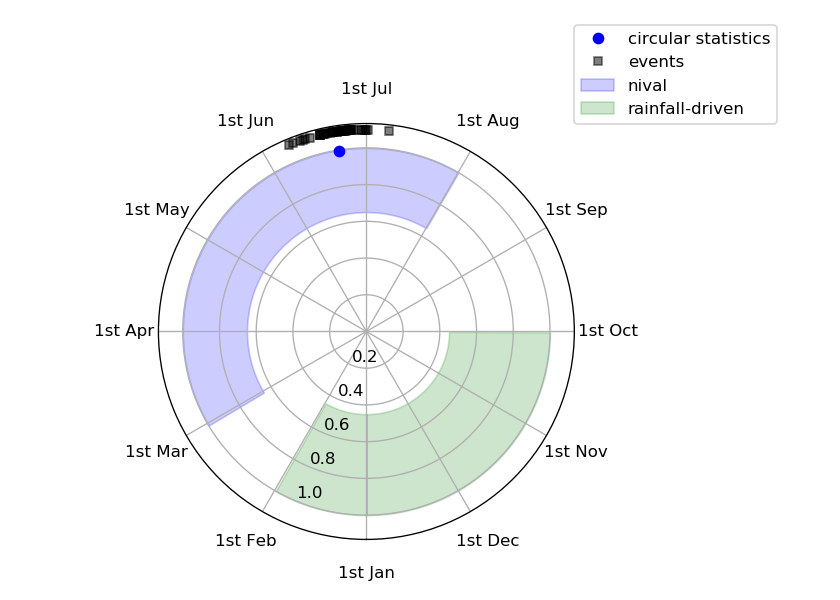

In [24]:
# Polar plot
fig = polar_plot(theta_rad_events_COM, regime_COM_gdf.circular_stats_regularity.values, flag=0, nival_start_doy=nival_start_doy_default, nival_end_doy=nival_end_doy_default, nival_regularity_threshold=nival_regularity_threshold_default)

In [22]:
# Save the figure
fig.savefig(settings['plots_path']+"polar_plot_COM_basin"+settings['domain']+".png", dpi=300)

In [23]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)